# **MiniROCKET Time-Series Model (Dangerous Trip Detection)**

This notebook trains and evaluates a **time-series** classification model using **MiniROCKET**.
MiniROCKET is a fast, high-performing method for time-series classification that transforms raw time-series into a large feature vector using random convolutional kernels, then trains a simple linear classifier.

##### Dataset context (from your pipeline)
You have long-format sensor time-series data where each row represents a sensor reading at a specific second of a trip:
- `bookingID` identifies a trip
- `second` is the time index within the trip
- `is_dangerous_trip` is the trip label (0/1)
- remaining columns are sensor features (speed, accel, gyro, bearing, etc.)

##### Split policy (IMPORTANT, do not violate)
- **Train split**: used only to fit models
- **Validation split**: used to compare ALL candidate models and choose best parameters / best approach
- **Test split**: used exactly once to evaluate the final chosen approach (no tuning on test)

This notebook follows the ML experimentation stages:
- **Stage A (Baseline)**: train baseline MiniROCKET model, evaluate on validation
- **Stage B (Tuning)**: tune key hyperparameters using validation, select best configuration
- **Stage C (Improvement)**: apply an improvement strategy using best Stage B params and compare on validation
- **Final**: retrain best approach on (train + validation), evaluate once on test

##### MLflow tracking (Azure DB-backed)
Our team runs the MLflow UI server with an Azure PostgreSQL backend store (shared for group collaboration).
This notebook logs runs to that MLflow server (tracking URI), and the server writes results to the Azure DB.

---

#

## **Imports and reproducibility settings**

We import:
- pandas/numpy for data handling
- matplotlib for plots (simple, reproducible)
- scikit-learn for evaluation metrics and linear classifier
- sktime MiniRocketMultivariate for time-series feature transformation
- mlflow for experiment tracking

We also set:
- random seed for reproducibility
- display options for easier inspection

---

In [1]:
# core python
import os
import json
import time
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Tuple

# data
import numpy as np
import pandas as pd

# plots
import matplotlib.pyplot as plt

# sklearn
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score,
    precision_score,
    recall_score,
)

# mlflow
import mlflow
import mlflow.sklearn

# sktime (MiniROCKET)
try:
    from sktime.transformations.panel.rocket import MiniRocketMultivariate
except Exception as e:
    raise ImportError(
        "MiniRocketMultivariate import failed. "
        "Fix by installing/upgrading sktime: pip install -U sktime"
    ) from e

# notebook display helper (prevents 'display' undefined)
from IPython.display import display

# optional: reduce warnings noise
import warnings
warnings.filterwarnings("ignore")

# reproducibility
SEED = 42
np.random.seed(SEED)

# pandas display
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

def make_run_name(stage: str, name: str) -> str:
    """
    Standardize MLflow run names so they all follow:
      StageA_<something>, StageB_<something>, StageC_<something>, Final_<something>
    """
    stage = stage.strip()
    name = name.strip()
    return f"{stage}_{name}"

#

## **Folder architecture and path setup (matches Sprint 2 structure)**

Based on project tree, notebook is located under:
`Sprint 2/Modelling/ts_minirocket.ipynb`

and datasets are stored under:
`Sprint 2/Datasets/time_series_...`

We will save:
- generated plots and reports to: `Sprint 2/Modelling/artifacts/`
- final model bundles to: `Sprint 2/Modelling/models/`

This keeps all modelling outputs in the correct location for submission and for GUI (Tkinter) integration.

---

In [2]:
# find the "Sprint 2" directory robustly, starting from current working directory
# this helps even if you run the notebook from different working directories
cwd = Path.cwd().resolve()

def find_parent_dir(start: Path, target_name: str, max_up: int = 6) -> Path:
    """Walk upwards from start to find a parent directory named target_name."""
    cur = start
    for _ in range(max_up):
        if cur.name == target_name:
            return cur
        if cur.parent == cur:
            break
        cur = cur.parent
    return start  # fallback

SPRINT2_DIR = find_parent_dir(cwd, "Sprint 2")

# define dataset directory and modelling output dirs based on your architecture
DATASETS_DIR = SPRINT2_DIR / "Datasets"
MODELLING_DIR = SPRINT2_DIR / "Modelling"
ARTIFACTS_DIR = MODELLING_DIR / "artifacts"
MODELS_DIR = MODELLING_DIR / "models"

# create output dirs if they do not exist
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# dataset file paths (match your filenames)
BASE_CSV = DATASETS_DIR / "time_series_data" / "timeseries_v1_base.csv"
HYBRID_CSV = DATASETS_DIR / "time_series_data" / "timeseries_v1_hybrid.csv"  # optional for future improvements
SPLIT_CSV = DATASETS_DIR / "time_series_data" / "timeseries_v1_trip_split.csv"

print("SPRINT2_DIR:", SPRINT2_DIR)
print("BASE_CSV:", BASE_CSV)
print("SPLIT_CSV:", SPLIT_CSV)
print("ARTIFACTS_DIR:", ARTIFACTS_DIR)
print("MODELS_DIR:", MODELS_DIR)

SPRINT2_DIR: C:\Users\123\OneDrive - Singapore Polytechnic\AY20252026\PAI-PC-VERS\PAI-GoBest-Project\Sprint 2
BASE_CSV: C:\Users\123\OneDrive - Singapore Polytechnic\AY20252026\PAI-PC-VERS\PAI-GoBest-Project\Sprint 2\Datasets\time_series_data\timeseries_v1_base.csv
SPLIT_CSV: C:\Users\123\OneDrive - Singapore Polytechnic\AY20252026\PAI-PC-VERS\PAI-GoBest-Project\Sprint 2\Datasets\time_series_data\timeseries_v1_trip_split.csv
ARTIFACTS_DIR: C:\Users\123\OneDrive - Singapore Polytechnic\AY20252026\PAI-PC-VERS\PAI-GoBest-Project\Sprint 2\Modelling\artifacts
MODELS_DIR: C:\Users\123\OneDrive - Singapore Polytechnic\AY20252026\PAI-PC-VERS\PAI-GoBest-Project\Sprint 2\Modelling\models


#

## **MLflow tracking setup (Azure DB-backed via MLflow server)**

Important detail:
- The notebook does NOT connect directly to Azure PostgreSQL.
- Team runs MLflow UI server locally with:

  python -m mlflow ui `
    --backend-store-uri "postgresql://...@pai-gobest.postgres.database.azure.com:5432/pai-db?sslmode=require" `
    --host 127.0.0.1 `
    --port 5000

That means:
- This notebook logs to `http://127.0.0.1:5000`
- The MLflow server writes runs and metrics into the Azure DB backend store
- Everyone in the group can see the same experiment history (collaborative MLflow)

We set:
- tracking URI
- experiment name
- common tags to keep runs organized (model name, dataset version, etc.)

---

In [3]:
# global containers so downstream cells don't explode when rerun out-of-order
# these prevent NameError if  accidentally run plotting/final cells first

stage_results = []   # stores summary metrics for stage comparison
trials = []          # stores Stage B tuning trials
df_trials = None     # dataframe view of trials
best_trial = None    # best hyperparams from Stage B

# mlflow tracking (MLflow server uses Azure PostgreSQL as backend store)
# NOTE: the notebook logs to the MLflow server; the server writes to Azure DB
MLFLOW_TRACKING_URI = os.getenv("MLFLOW_TRACKING_URI", "http://127.0.0.1:5000")
EXPERIMENT_NAME = os.getenv("MLFLOW_EXPERIMENT_NAME", "ts_minirocket")

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

print("MLFLOW_TRACKING_URI:", MLFLOW_TRACKING_URI)
print("EXPERIMENT_NAME:", EXPERIMENT_NAME)

MLFLOW_TRACKING_URI: http://127.0.0.1:5000
EXPERIMENT_NAME: ts_minirocket


#

## **Load datasets and validate schema**

We load:
- `timeseries_v1_base.csv` (long format time-series)
- `timeseries_v1_trip_split.csv` (trip-level split mapping)

We validate:
- required columns exist
- bookingID types are consistent (cast to string)
- split values are present (train/val/test)

We also compute a trip-level label table:
- each bookingID has 1 label (dangerous if any row indicates dangerous)
This ensures the model is evaluated at the trip level, not row level.

---

In [4]:
# load datasets
df_base = pd.read_csv(BASE_CSV)
df_split = pd.read_csv(SPLIT_CSV)

# basic cleanup: strip column names
df_base.columns = [c.strip() for c in df_base.columns]
df_split.columns = [c.strip() for c in df_split.columns]

# required columns
required_base = {"bookingID", "second", "is_dangerous_trip"}
required_split = {"bookingID", "split"}

missing_base = [c for c in required_base if c not in df_base.columns]
missing_split = [c for c in required_split if c not in df_split.columns]

if missing_base:
    raise ValueError(f"Missing required columns in base dataset: {missing_base}")
if missing_split:
    raise ValueError(f"Missing required columns in split dataset: {missing_split}")

# enforce consistent types
df_base["bookingID"] = df_base["bookingID"].astype(str)
df_split["bookingID"] = df_split["bookingID"].astype(str)

# normalize split labels (VS: could be 'validation' instead of 'val')
df_split["split"] = df_split["split"].astype(str).str.strip().str.lower()
df_split["split"] = df_split["split"].replace({
    "valid": "val",
    "validation": "val",
    "dev": "val",
})

# CHECK: if "val" is missing, we need to manually split "train" into "train" + "val"
unique_splits = set(df_split["split"].unique())
if "val" not in unique_splits and "train" in unique_splits:
    print("WARNING: No 'val' split found in split file.")
    print("Automatically splitting 'train' into train/val (70/30 by trips)...")
    
    # get all train trip bookingIDs
    train_bookings = df_split[df_split["split"] == "train"]["bookingID"].unique()
    print(f"   Found {len(train_bookings)} unique train trips")
    
    # randomly split train into train/val at trip level (stratified by label)
    df_train_trips = (
        df_base[df_base["bookingID"].isin(train_bookings)]
        .groupby("bookingID")["is_dangerous_trip"]
        .max()
        .rename("label")
        .reset_index()
    )
    
    # stratified split: 70% train, 30% val (stratified by label)
    from sklearn.model_selection import train_test_split
    
    train_trips, val_trips = train_test_split(
        df_train_trips["bookingID"].tolist(),
        test_size=0.30,
        random_state=SEED,
        stratify=df_train_trips["label"].tolist()
    )
    
    print(f"   After split: {len(train_trips)} train trips, {len(val_trips)} val trips")
        
    # update df_split with new train/val split
    df_split_new = df_split[df_split["split"] != "train"].copy()
    
    train_split = pd.DataFrame({
        "bookingID": train_trips,
        "split": "train"
    })
    val_split = pd.DataFrame({
        "bookingID": val_trips,
        "split": "val"
    })
    
    df_split = pd.concat([df_split_new, train_split, val_split], axis=0).reset_index(drop=True)
    print(f"   Updated df_split with new train/val split")

# merge split into base
df = df_base.merge(df_split, on="bookingID", how="inner")
if len(df) == 0:
    raise ValueError(
        "After merging df_base with df_split, df is empty. "
        "This means bookingIDs do not match. Check your split file vs base file."
    )
    
# check split distribution
print("Row counts by split:")
print(df["split"].value_counts(dropna=False))

# trip-level labels (one label per trip)
df_trip = (
    df.groupby("bookingID")["is_dangerous_trip"]
      .max()
      .astype(int)
      .rename("label")
      .reset_index()
      .merge(df_split, on="bookingID", how="inner")
)

print("\nTrip counts by split:")
print(df_trip["split"].value_counts())

# define sensor columns EARLY (never depend on EDA cell)
exclude = {"bookingID", "second", "is_dangerous_trip", "split"}
sensor_cols = [c for c in df.columns if c not in exclude]

if len(sensor_cols) == 0:
    raise ValueError("No sensor columns found. Check your base dataset columns.")

print("\nsensor_cols:", sensor_cols)

# ensure required splits exist
missing_splits = [s for s in ["train", "val", "test"] if s not in set(df["split"].unique())]
if missing_splits:
    raise ValueError(
        f"Missing required split(s): {missing_splits}. "
        f"Found splits: {sorted(df['split'].unique().tolist())}. "
        "Fix the split mapping file or the normalization mapping above."
    )

Automatically splitting 'train' into train/val (70/30 by trips)...
   Found 15977 unique train trips
   After split: 11183 train trips, 4794 val trips
   Updated df_split with new train/val split
Row counts by split:
split
train    4051413
val      1738455
test     1446711
Name: count, dtype: int64

Trip counts by split:
split
train    11183
val       4794
test      3995
Name: count, dtype: int64

sensor_cols: ['speed', 'acceleration_x', 'acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z', 'bearing', 'accuracy']



#

## **Quick EDA to understand the time-series data (plots included)**

Before training models, we inspect:
- how many trips per split
- class imbalance (dangerous vs safe)
- distribution of trip lengths (number of rows per bookingID)
- example sensor traces for 1 safe trip and 1 dangerous trip

This helps explain:
- why we resample trips to fixed length
- whether class imbalance handling is needed (we use class_weight='balanced' in baseline)

---

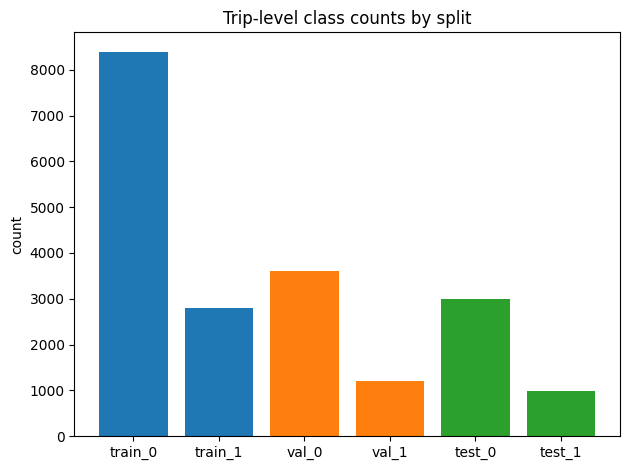

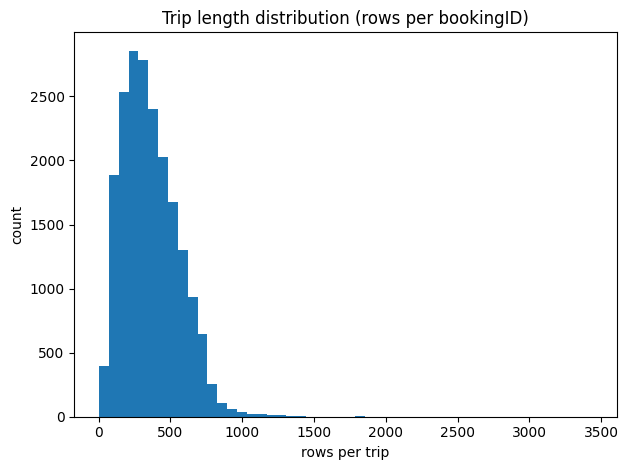

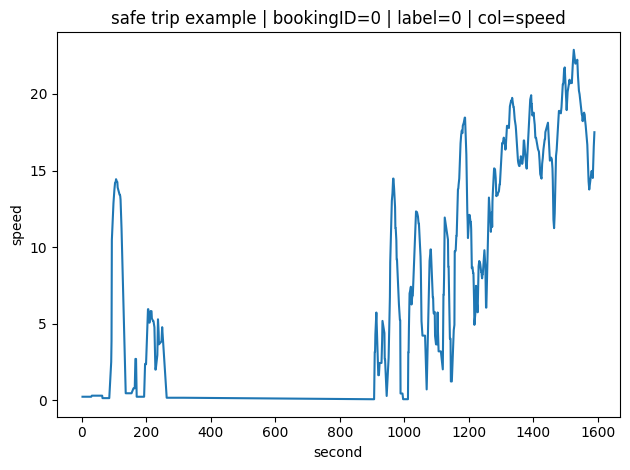

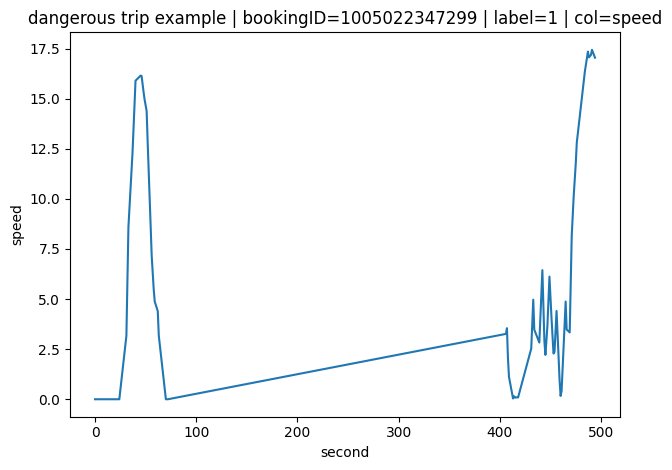

In [5]:
# plot 1: trip-level label balance per split
fig = plt.figure()
for i, s in enumerate(["train", "val", "test"], start=1):
    sub = df_trip[df_trip["split"] == s]
    if len(sub) == 0:
        continue
    counts = sub["label"].value_counts().sort_index()
    plt.bar([f"{s}_0", f"{s}_1"], [counts.get(0, 0), counts.get(1, 0)])
plt.title("Trip-level class counts by split")
plt.ylabel("count")
fig.tight_layout()
eda_path = ARTIFACTS_DIR / "eda_trip_label_counts.png"
fig.savefig(eda_path, dpi=160)
plt.show()
plt.close(fig)

# plot 2: trip length distribution (rows per bookingID)
trip_lengths = df.groupby("bookingID").size().rename("n_rows").reset_index()
fig = plt.figure()
plt.hist(trip_lengths["n_rows"], bins=50)
plt.title("Trip length distribution (rows per bookingID)")
plt.xlabel("rows per trip")
plt.ylabel("count")
fig.tight_layout()
len_path = ARTIFACTS_DIR / "eda_trip_length_hist.png"
fig.savefig(len_path, dpi=160)
plt.show()
plt.close(fig)

# plot 3: sample sensor trace
# pick one safe and one dangerous trip from train split for a quick visual
train_trips = df_trip[df_trip["split"] == "train"]
safe_ids = train_trips[train_trips["label"] == 0]["bookingID"].tolist()
dang_ids = train_trips[train_trips["label"] == 1]["bookingID"].tolist()

# choose ids if available
safe_id = safe_ids[0] if len(safe_ids) else None
dang_id = dang_ids[0] if len(dang_ids) else None

# choose a sensor column to plot (speed usually makes sense)
exclude = {"bookingID", "second", "is_dangerous_trip", "split"}
sensor_cols = [c for c in df.columns if c not in exclude]
plot_col = "speed" if "speed" in sensor_cols else sensor_cols[0]

def plot_trip_trace(bid: str, label: int, name: str):
    """Plot a time-series trace for one trip."""
    trip_df = df[df["bookingID"] == bid].sort_values("second") # type: ignore 
    fig = plt.figure()
    plt.plot(trip_df["second"], trip_df[plot_col])
    plt.title(f"{name} trip example | bookingID={bid} | label={label} | col={plot_col}")
    plt.xlabel("second")
    plt.ylabel(plot_col)
    fig.tight_layout()
    out_path = ARTIFACTS_DIR / f"eda_trip_trace_{name}.png"
    fig.savefig(out_path, dpi=160)
    plt.show()
    plt.close(fig)

if safe_id is not None:
    plot_trip_trace(safe_id, 0, "safe")
if dang_id is not None:
    plot_trip_trace(dang_id, 1, "dangerous")

#

## **Convert long-format trips into fixed-length multivariate series (required for MiniROCKET)**

MiniROCKET (and most classical time-series classifiers) expects each sample to be a time-series of equal length.

Problem:
- each trip has a different number of time steps (variable length)

Solution:
- for each bookingID:
  1) sort by `second`
  2) interpolate each sensor channel onto a fixed grid of length L
  3) produce an array with shape: (n_trips, n_channels, L)

We also support an improvement feature for Stage C:
- delta channels (first difference per sensor)
This captures rapid changes (sudden acceleration / turns), which often correlate with dangerous trips.

---

In [6]:
@dataclass
class SeriesBuildConfig:
    # fixed length for each trip after resampling
    series_length: int = 256
    # whether to append delta channels (first differences)
    add_deltas: bool = False

def resample_trip(trip_df: pd.DataFrame, cols: List[str], L: int) -> np.ndarray:
    """
    Resample one trip into fixed length L using linear interpolation per channel.

    Returns:
        Xi: np.ndarray of shape (n_channels, L)
    """
    # sort by time
    trip_df = trip_df.sort_values("second")

    # original time values
    t = trip_df["second"].to_numpy(dtype=float)

    # handle edge case: too few points
    if len(t) < 2:
        # fallback: repeat first row
        x = trip_df[cols].to_numpy(dtype=float)
        if len(x) == 0:
            return np.zeros((len(cols), L), dtype=float)
        return np.tile(x[0].reshape(-1, 1), (1, L))

    # target grid
    t_new = np.linspace(t.min(), t.max(), L)

    # interpolate each channel
    Xc = []
    for c in cols:
        y = trip_df[c].to_numpy(dtype=float)
        y_new = np.interp(t_new, t, y)
        Xc.append(y_new)

    return np.stack(Xc, axis=0)

def build_panel(df_long: pd.DataFrame, cfg: SeriesBuildConfig, cols: List[str] = None) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Convert long dataframe into:
        X: shape (n_trips, n_channels, L)
        y: shape (n_trips,)
        channel_names: list of channel names used

    Key improvement:
    - This function no longer relies on global sensor_cols.
    - If cols is None, it will infer sensor columns from df_long.
    """
    # infer sensor columns if not provided
    if cols is None:
        exclude_local = {"bookingID", "second", "is_dangerous_trip", "split"}
        cols = [c for c in df_long.columns if c not in exclude_local]
        if len(cols) == 0:
            raise ValueError("build_panel could not infer sensor columns (cols list is empty).")

    # trip-level label (use max to ensure any dangerous row => dangerous trip)
    y_trip = (
        df_long.groupby("bookingID")["is_dangerous_trip"]
              .max()
              .astype(int)
    )
    booking_ids = y_trip.index.tolist()

    # build X by resampling each trip
    X_list = []
    for bid in booking_ids:
        trip_df = df_long[df_long["bookingID"] == bid]
        Xi = resample_trip(trip_df, cols, cfg.series_length)
        X_list.append(Xi)

    X = np.stack(X_list, axis=0)
    y = y_trip.to_numpy()

    channel_names = cols.copy()

    # add delta channels if requested
    if cfg.add_deltas:
        dX = np.diff(X, axis=2, prepend=X[:, :, :1])
        X = np.concatenate([X, dX], axis=1)
        channel_names = channel_names + [f"{c}_delta" for c in cols]

    return X, y, channel_names

# split long dataframe (guarded)
if "df" not in globals():
    raise NameError("df is not defined. Run the data loading cell first (Cell 13).")

df_train = df[df["split"] == "train"].copy()
df_val = df[df["split"] == "val"].copy()
df_test = df[df["split"] == "test"].copy()

# guard: empty splits will cause np.stack to crash later
if df_train["bookingID"].nunique() == 0:
    raise ValueError("df_train has 0 trips. Check your split file.")
if df_val["bookingID"].nunique() == 0:
    raise ValueError("df_val has 0 trips. Check your split file (val/validation naming).")
if df_test["bookingID"].nunique() == 0:
    raise ValueError("df_test has 0 trips. Check your split file.")

print("train trips:", df_train["bookingID"].nunique())
print("val trips:", df_val["bookingID"].nunique())
print("test trips:", df_test["bookingID"].nunique())

train trips: 11183
val trips: 4794
test trips: 3995


#

## **Evaluation utilities + plots**

To compare models properly on validation, we compute:
- F1, precision, recall at a chosen decision threshold
- ROC-AUC using continuous scores
- classification report (per-class)
- plots:
  - confusion matrix
  - ROC curve
  - PR curve
  - score distribution histogram (helps explain threshold selection)

These artifacts are saved locally to `Sprint 2/Modelling/artifacts/`
and logged into MLflow for experiment tracking.

---

In [7]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    """Convert logits to probabilities in a stable way."""
    x = np.clip(x, -50, 50)
    return 1.0 / (1.0 + np.exp(-x))

def get_score(clf, X_feat: np.ndarray) -> np.ndarray:
    """
    Get continuous scores for ROC/PR curves.
    - prefer predict_proba
    - otherwise use decision_function and sigmoid
    """
    if hasattr(clf, "predict_proba"):
        return clf.predict_proba(X_feat)[:, 1]
    if hasattr(clf, "decision_function"):
        return sigmoid(clf.decision_function(X_feat))
    return clf.predict(X_feat).astype(float)

def compute_metrics(y_true: np.ndarray, y_score: np.ndarray, threshold: float) -> Dict[str, float]:
    """Compute classification metrics for a given threshold."""
    y_pred = (y_score >= threshold).astype(int)

    out = {
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
    }

    # ROC-AUC requires both classes present
    if len(np.unique(y_true)) == 2:
        out["roc_auc"] = roc_auc_score(y_true, y_score)
    else:
        out["roc_auc"] = float("nan")
    return out

def save_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, out_path: Path, title: str):
    """Save confusion matrix plot."""
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.xticks([0, 1], ["0", "1"])
    plt.yticks([0, 1], ["0", "1"])

    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")

    fig.tight_layout()
    fig.savefig(out_path, dpi=160)
    plt.close(fig)

def save_roc_curve(y_true: np.ndarray, y_score: np.ndarray, out_path: Path, title: str):
    """Save ROC curve plot."""
    if len(np.unique(y_true)) < 2:
        return
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_val = auc(fpr, tpr)

    fig = plt.figure()
    plt.plot(fpr, tpr)
    plt.title(f"{title} | auc={roc_val:.4f}")
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    fig.tight_layout()
    fig.savefig(out_path, dpi=160)
    plt.close(fig)

def save_pr_curve(y_true: np.ndarray, y_score: np.ndarray, out_path: Path, title: str):
    """Save Precision-Recall curve plot."""
    if len(np.unique(y_true)) < 2:
        return
    p, r, _ = precision_recall_curve(y_true, y_score)
    pr_val = auc(r, p)

    fig = plt.figure()
    plt.plot(r, p)
    plt.title(f"{title} | auc={pr_val:.4f}")
    plt.xlabel("recall")
    plt.ylabel("precision")
    fig.tight_layout()
    fig.savefig(out_path, dpi=160)
    plt.close(fig)

def save_score_hist(y_true: np.ndarray, y_score: np.ndarray, out_path: Path, title: str):
    """Save score distribution histogram split by class."""
    fig = plt.figure()
    plt.hist(y_score[y_true == 0], bins=30, alpha=0.7, label="class 0")
    plt.hist(y_score[y_true == 1], bins=30, alpha=0.7, label="class 1")
    plt.title(title)
    plt.xlabel("score")
    plt.ylabel("count")
    plt.legend()
    fig.tight_layout()
    fig.savefig(out_path, dpi=160)
    plt.close(fig)

def log_artifacts_to_mlflow(paths: List[Path]):
    """Log local files to MLflow."""
    for p in paths:
        if p.exists():
            mlflow.log_artifact(str(p))

#

## **Stage A: Baseline model (MiniROCKET + Logistic Regression)**

Baseline design:
- Transformer: MiniRocketMultivariate (num_kernels fixed)
- Classifier: LogisticRegression (balanced class weights)

Why this baseline is strong:
- MiniROCKET extracts many time-series features efficiently
- Logistic regression is fast and stable
- Balanced class weights handle class imbalance without oversampling

Process:
1) Build fixed-length series from TRAIN and VALIDATION
2) Fit on TRAIN only
3) Evaluate on VALIDATION only
4) Save plots and log everything into MLflow

---

X_train: (11183, 9, 256) y_train: (11183,)
X_val: (4794, 9, 256) y_val: (4794,)
channels: 9


2026/02/01 05:14:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/01 05:14:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Stage A validation metrics: {'f1': 0.38229533881707795, 'precision': 0.3593519882179676, 'recall': 0.40836820083682007, 'roc_auc': np.float64(0.6316245447073281)}
🏃 View run StageA_baseline_minirocket_logreg at: http://127.0.0.1:5000/#/experiments/22/runs/a572d7ef759f409989f9741a5e9e8078
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/22


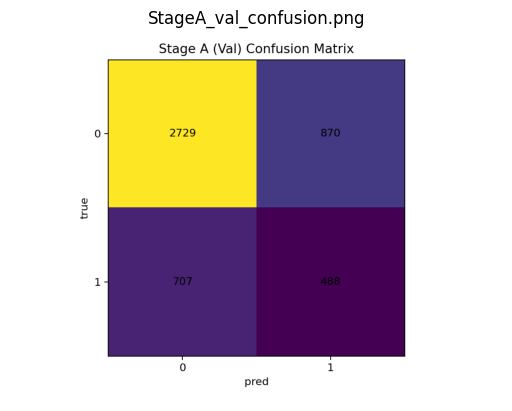

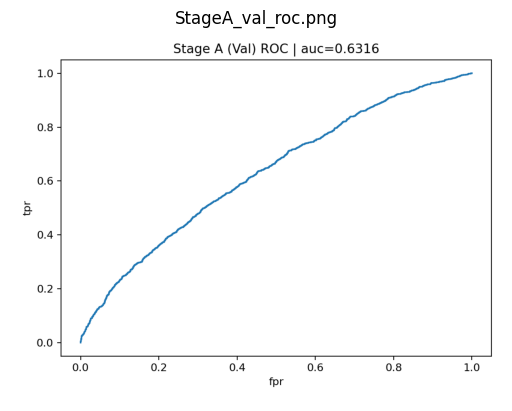

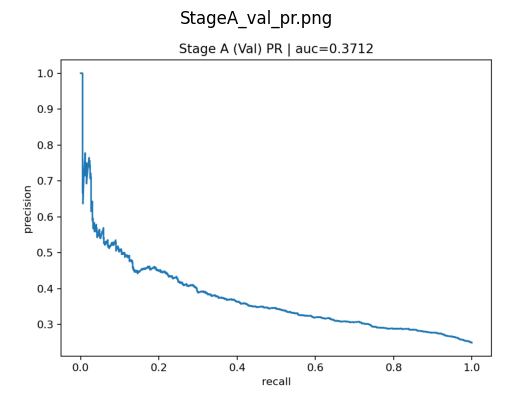

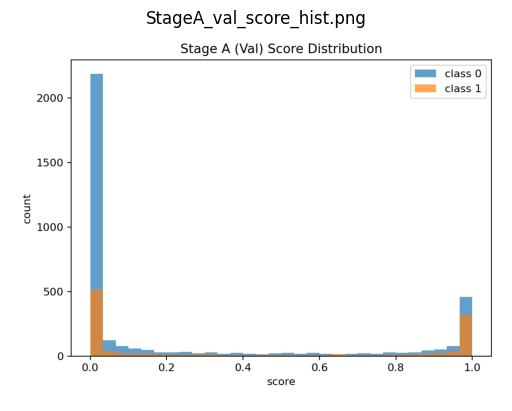

In [8]:
# stage a config
stage_a_cfg = SeriesBuildConfig(series_length=256, add_deltas=False)

# build train/val arrays
X_train, y_train, ch_names = build_panel(df_train, stage_a_cfg)
X_val, y_val, _ = build_panel(df_val, stage_a_cfg)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("channels:", len(ch_names))

# define baseline pipeline
baseline_pipeline = Pipeline([
    ("rocket", MiniRocketMultivariate(num_kernels=10_000, random_state=SEED)),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(
        solver="lbfgs",
        max_iter=2000,
        class_weight="balanced",
        random_state=SEED
    )),
])

run_name = make_run_name("StageA", "baseline_minirocket_logreg")

with mlflow.start_run(run_name=run_name):
    # tags to help filtering
    mlflow.set_tag("stage", "A")
    mlflow.set_tag("model_family", "minirocket")
    mlflow.set_tag("dataset", "timeseries_v1_base")

    # log params
    mlflow.log_param("series_length", stage_a_cfg.series_length)
    mlflow.log_param("add_deltas", stage_a_cfg.add_deltas)
    mlflow.log_param("num_kernels", 10_000)
    mlflow.log_param("classifier", "logreg")
    mlflow.log_param("class_weight", "balanced")

    # fit on train
    t0 = time.time()
    baseline_pipeline.fit(X_train, y_train)
    train_time = time.time() - t0
    mlflow.log_metric("train_time_sec", train_time)

    # score on val
    rocket = baseline_pipeline.named_steps["rocket"]
    scaler = baseline_pipeline.named_steps["scaler"]
    clf = baseline_pipeline.named_steps["clf"]

    X_val_feat = scaler.transform(rocket.transform(X_val))
    y_val_score = get_score(clf, X_val_feat)

    # baseline threshold
    threshold = 0.50
    metrics = compute_metrics(y_val, y_val_score, threshold)

    # log metrics
    mlflow.log_param("threshold", threshold)
    mlflow.log_metric("val_f1", metrics["f1"])
    mlflow.log_metric("val_precision", metrics["precision"])
    mlflow.log_metric("val_recall", metrics["recall"])
    mlflow.log_metric("val_roc_auc", metrics["roc_auc"])

    # artifacts
    y_val_pred = (y_val_score >= threshold).astype(int)

    cm_path = ARTIFACTS_DIR / "StageA_val_confusion.png"
    roc_path = ARTIFACTS_DIR / "StageA_val_roc.png"
    pr_path = ARTIFACTS_DIR / "StageA_val_pr.png"
    hist_path = ARTIFACTS_DIR / "StageA_val_score_hist.png"
    rpt_path = ARTIFACTS_DIR / "StageA_val_report.txt"

    save_confusion_matrix(y_val, y_val_pred, cm_path, "Stage A (Val) Confusion Matrix")
    save_roc_curve(y_val, y_val_score, roc_path, "Stage A (Val) ROC")
    save_pr_curve(y_val, y_val_score, pr_path, "Stage A (Val) PR")
    save_score_hist(y_val, y_val_score, hist_path, "Stage A (Val) Score Distribution")
    rpt_path.write_text(classification_report(y_val, y_val_pred, digits=4, zero_division=0))

    log_artifacts_to_mlflow([cm_path, roc_path, pr_path, hist_path, rpt_path])

    # log model to mlflow (required)
    mlflow.sklearn.log_model(baseline_pipeline, artifact_path="model")

    # update stage_results (global)
    stage_results.append({
        "stage": "A",
        "name": "baseline",
        "threshold": threshold,
        "train_time_sec": train_time,
        **metrics
    })

    print("Stage A validation metrics:", metrics)

# show plots inline
for p in [cm_path, roc_path, pr_path, hist_path]:
    if p.exists():
        img = plt.imread(p)
        plt.figure()
        plt.imshow(img)
        plt.axis("off")
        plt.title(p.name)
        plt.show()
        plt.close()

#

## **Stage B: Hyperparameter tuning (validation decides best)**

In Stage B, we search for the best configuration using VALIDATION only.

What we tune (reasonable + reportable):
- `num_kernels` (MiniROCKET capacity vs speed tradeoff)
- Logistic regression `C` (regularization strength)
- decision threshold (to maximize validation F1)

Why tune threshold?
- If class distribution is imbalanced, a default 0.5 threshold is often suboptimal.
- Selecting threshold using VALIDATION is allowed (it is part of model selection).
- We will NOT touch TEST during tuning.

Outputs:
- MLflow logs each trial
- A local table of results is created
- Plots are generated:
  - val_f1 vs num_kernels
  - val_f1 vs C
  - train_time vs num_kernels
These plots make Stage B look "real" (because it is).

---

In [9]:
# guard: you must have the data splits and build_panel ready
if "df_train" not in globals() or "df_val" not in globals():
    raise NameError("df_train/df_val not defined. Run the series-builder/split cell (Cell 19).")

# stage b config (keep series_length same as stage A so comparisons are fair)
stage_b_cfg = SeriesBuildConfig(series_length=256, add_deltas=False)

# rebuild train/val arrays (explicitly pass cols to avoid relying on globals)
X_train, y_train, _ = build_panel(df_train, stage_b_cfg, cols=sensor_cols)
X_val, y_val, _ = build_panel(df_val, stage_b_cfg, cols=sensor_cols)

# tuning grids
kernel_grid = [2000, 5000, 10000]
C_grid = [0.1, 0.3, 1.0, 3.0, 10.0]
threshold_grid = [0.30, 0.40, 0.50, 0.60, 0.70]

# reset containers cleanly each time you run Stage B
trials = []
best_trial = None
best_val_f1 = -1.0

# parent run is REQUIRED because you are using nested runs for each trial
parent_run_name = make_run_name("StageB", "tuning_parent")

with mlflow.start_run(run_name=parent_run_name):
    mlflow.set_tag("stage", "B")
    mlflow.set_tag("model_family", "minirocket")
    mlflow.set_tag("dataset", "timeseries_v1_base")

    # log search space
    mlflow.log_param("kernel_grid", kernel_grid)
    mlflow.log_param("C_grid", C_grid)
    mlflow.log_param("threshold_grid", threshold_grid)
    mlflow.log_param("series_length", stage_b_cfg.series_length)
    mlflow.log_param("add_deltas", stage_b_cfg.add_deltas)

    for num_kernels in kernel_grid:
        for C in C_grid:
            # create pipeline for this trial
            pipe = Pipeline([
                ("rocket", MiniRocketMultivariate(num_kernels=num_kernels, random_state=SEED)),
                ("scaler", StandardScaler(with_mean=True, with_std=True)),
                ("clf", LogisticRegression(
                    solver="lbfgs",
                    max_iter=2000,
                    class_weight="balanced",
                    C=C,
                    random_state=SEED
                )),
            ])

            run_name = make_run_name("StageB", f"k{num_kernels}_C{C}")

            with mlflow.start_run(run_name=run_name, nested=True):
                mlflow.set_tag("stage", "B")
                mlflow.set_tag("model_family", "minirocket")
                mlflow.set_tag("dataset", "timeseries_v1_base")

                # log params
                mlflow.log_param("num_kernels", num_kernels)
                mlflow.log_param("C", C)
                mlflow.log_param("classifier", "logreg")
                mlflow.log_param("class_weight", "balanced")

                # fit on train
                t0 = time.time()
                pipe.fit(X_train, y_train)
                train_time = time.time() - t0
                mlflow.log_metric("train_time_sec", train_time)

                # score on validation
                rocket = pipe.named_steps["rocket"]
                scaler = pipe.named_steps["scaler"]
                clf = pipe.named_steps["clf"]

                X_val_feat = scaler.transform(rocket.transform(X_val))
                y_val_score = get_score(clf, X_val_feat)

                # choose best threshold by validation F1
                best_thr = None
                best_metrics = None
                best_f1 = -1.0

                for thr in threshold_grid:
                    m = compute_metrics(y_val, y_val_score, thr)
                    if m["f1"] > best_f1:
                        best_f1 = m["f1"]
                        best_thr = thr
                        best_metrics = m

                # log threshold and metrics
                mlflow.log_param("threshold", best_thr)
                mlflow.log_metric("val_f1", best_metrics["f1"])
                mlflow.log_metric("val_precision", best_metrics["precision"])
                mlflow.log_metric("val_recall", best_metrics["recall"])
                mlflow.log_metric("val_roc_auc", best_metrics["roc_auc"])

                # REQUIRED: log model for each Stage B trial
                mlflow.sklearn.log_model(pipe, artifact_path="model")

                # record trial locally
                trial = {
                    "num_kernels": num_kernels,
                    "C": C,
                    "threshold": best_thr,
                    "train_time_sec": train_time,
                    **best_metrics
                }
                trials.append(trial)

                # update global best
                if best_metrics["f1"] > best_val_f1:
                    best_val_f1 = best_metrics["f1"]
                    best_trial = trial

# build df_trials for plots
df_trials = pd.DataFrame(trials).sort_values("f1", ascending=False)

print("Best Stage B trial:", best_trial)
display(df_trials.head(10))

2026/02/01 05:37:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/01 05:37:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run StageB_k2000_C0.1 at: http://127.0.0.1:5000/#/experiments/22/runs/cb8d8543a0ee4e69b5064c284e01c1b4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/22


2026/02/01 05:38:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/01 05:38:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run StageB_k2000_C0.3 at: http://127.0.0.1:5000/#/experiments/22/runs/785df2a03524468088191d7292dd9163
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/22


2026/02/01 05:38:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/01 05:38:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run StageB_k2000_C1.0 at: http://127.0.0.1:5000/#/experiments/22/runs/32c96c86de2d434dbd1eaa9ca72ef6da
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/22


2026/02/01 05:39:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/01 05:39:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run StageB_k2000_C3.0 at: http://127.0.0.1:5000/#/experiments/22/runs/38f601a1ce70491bac72b23c24571afc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/22


2026/02/01 05:39:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/01 05:39:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run StageB_k2000_C10.0 at: http://127.0.0.1:5000/#/experiments/22/runs/8b5ddd028b104df08e7e0466f8ad63d4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/22


2026/02/01 05:40:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/01 05:40:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run StageB_k5000_C0.1 at: http://127.0.0.1:5000/#/experiments/22/runs/f4e3141f72944f13860c11c14a0f21ee
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/22


2026/02/01 05:41:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/01 05:41:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run StageB_k5000_C0.3 at: http://127.0.0.1:5000/#/experiments/22/runs/1df11dafb8654694a961c411f8ff0cf8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/22


2026/02/01 05:42:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/01 05:42:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run StageB_k5000_C1.0 at: http://127.0.0.1:5000/#/experiments/22/runs/cbb4dc3b9f3147529a63d8704b9157ec
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/22


2026/02/01 05:43:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/01 05:43:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run StageB_k5000_C3.0 at: http://127.0.0.1:5000/#/experiments/22/runs/a3e2ae32f97a4370b29aa572a44fdcaf
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/22


2026/02/01 05:44:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/01 05:44:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run StageB_k5000_C10.0 at: http://127.0.0.1:5000/#/experiments/22/runs/a78156537bb543b4a74dc8f7718eafe0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/22


2026/02/01 05:45:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/01 05:46:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run StageB_k10000_C0.1 at: http://127.0.0.1:5000/#/experiments/22/runs/a8fb254c2d6b4c46b2b34e6d5e0ab788
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/22


2026/02/01 05:47:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/01 05:47:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run StageB_k10000_C0.3 at: http://127.0.0.1:5000/#/experiments/22/runs/c039054fc35a4534ae068724a21abf53
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/22


2026/02/01 05:48:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/01 05:48:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run StageB_k10000_C1.0 at: http://127.0.0.1:5000/#/experiments/22/runs/683f0b482fa14c1d8d467ce759b957d5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/22


2026/02/01 05:49:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/01 05:49:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run StageB_k10000_C3.0 at: http://127.0.0.1:5000/#/experiments/22/runs/0edf09e95a5d49c78672544e98e1e668
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/22


2026/02/01 05:50:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/01 05:50:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run StageB_k10000_C10.0 at: http://127.0.0.1:5000/#/experiments/22/runs/6b46c88c63ac4ffd824213ce1596bd1b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/22
🏃 View run StageB_tuning_parent at: http://127.0.0.1:5000/#/experiments/22/runs/16250dcd9ce54c59b47e7128233b8f7d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/22
Best Stage B trial: {'num_kernels': 2000, 'C': 0.1, 'threshold': 0.3, 'train_time_sec': 18.359807014465332, 'f1': 0.4578822286770531, 'precision': 0.33449074074074076, 'recall': 0.7255230125523012, 'roc_auc': np.float64(0.6765493901723049)}


,num_kernels,C,threshold,train_time_sec,f1,precision,recall,roc_auc
0,2000,0.1,0.3,18.359807,0.457882,0.334491,0.725523,0.676549
4,2000,10.0,0.4,19.651371,0.450755,0.352719,0.624268,0.667798
2,2000,1.0,0.4,19.177001,0.450738,0.352166,0.625941,0.668741
3,2000,3.0,0.4,19.519203,0.450287,0.352412,0.623431,0.667949
1,2000,0.3,0.3,19.037351,0.450107,0.331228,0.702092,0.671386
10,10000,0.1,0.3,55.503351,0.418256,0.352671,0.513808,0.641272
5,5000,0.1,0.3,34.859942,0.413275,0.330165,0.552301,0.639720
11,10000,0.3,0.3,59.914907,0.404255,0.350769,0.476987,0.635222
6,5000,0.3,0.4,41.792991,0.400559,0.343938,0.479498,0.629023
12,10000,1.0,0.3,60.341286,0.393106,0.349869,0.448536,0.631625


In [10]:
# guard: require Stage B to have found a best trial
if best_trial is None:
    raise NameError("best_trial is None. Run Stage B tuning first (Cell 28).")

best_num_kernels = int(best_trial["num_kernels"])
best_C = float(best_trial["C"])
best_threshold = float(best_trial["threshold"])

print("best_num_kernels:", best_num_kernels)
print("best_C:", best_C)
print("best_threshold:", best_threshold)

best_num_kernels: 2000
best_C: 0.1
best_threshold: 0.3


#

## **Stage B ablation plots (like gradient boosting notebook)**

We plot how validation performance and training time change with:
- `num_kernels` (capacity)
- `C` (regularization)

These plots are important for your writeup:
- they show you made decisions based on evidence
- they justify why you picked your final hyperparameters

All plots are saved into:
`Sprint 2/Modelling/artifacts/`

---

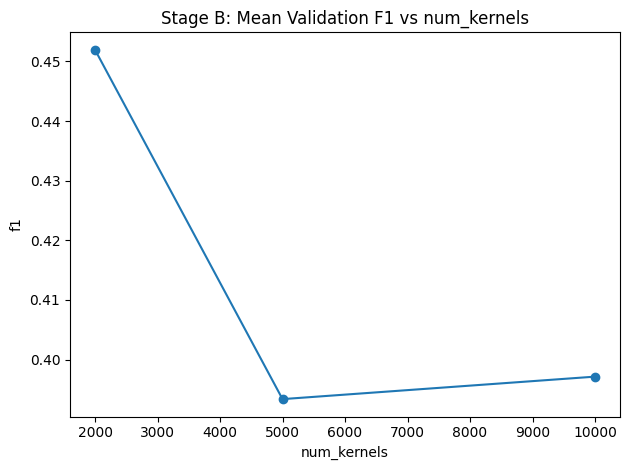

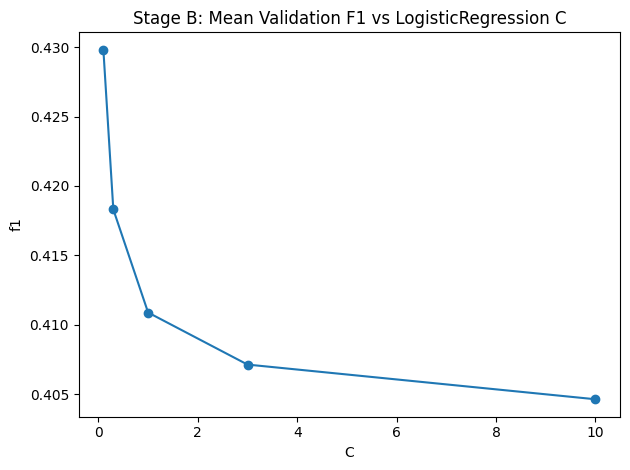

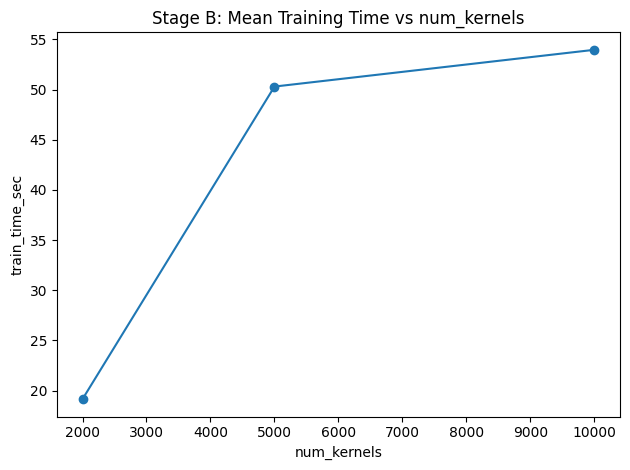

saved: C:\Users\123\OneDrive - Singapore Polytechnic\AY20252026\PAI-PC-VERS\PAI-GoBest-Project\Sprint 2\Modelling\artifacts\StageB_trials_table.csv


In [11]:
# guard: prevent "df_trials is not defined" if Stage B wasn't run yet
if df_trials is None or len(df_trials) == 0:
    raise NameError(
        "df_trials is not defined (or empty). "
        "Run the Stage B tuning cell FIRST, then rerun this plotting cell."
    )

# helper: average metrics grouped by a hyperparameter
def plot_grouped_metric(df_in: pd.DataFrame, group_col: str, metric_col: str, title: str, out_name: str):
    """Plot mean metric grouped by a column."""
    grouped = df_in.groupby(group_col)[metric_col].mean().reset_index()

    fig = plt.figure()
    plt.plot(grouped[group_col], grouped[metric_col], marker="o")
    plt.title(title)
    plt.xlabel(group_col)
    plt.ylabel(metric_col)
    fig.tight_layout()

    out_path = ARTIFACTS_DIR / out_name
    fig.savefig(out_path, dpi=160)
    plt.show()
    plt.close(fig)

# val f1 vs num_kernels
plot_grouped_metric(
    df_trials, "num_kernels", "f1",
    "Stage B: Mean Validation F1 vs num_kernels",
    "StageB_valf1_vs_num_kernels.png"
)

# val f1 vs C
plot_grouped_metric(
    df_trials, "C", "f1",
    "Stage B: Mean Validation F1 vs LogisticRegression C",
    "StageB_valf1_vs_C.png"
)

# train time vs num_kernels
plot_grouped_metric(
    df_trials, "num_kernels", "train_time_sec",
    "Stage B: Mean Training Time vs num_kernels",
    "StageB_train_time_vs_num_kernels.png"
)

# save tuning table
trials_csv_path = ARTIFACTS_DIR / "StageB_trials_table.csv"
df_trials.to_csv(trials_csv_path, index=False)
print("saved:", trials_csv_path)

#

## **Stage C: Improvement strategy (best params locked, compare on validation)**

Stage C rules:
- We DO NOT retune kernels or C again (those are chosen from Stage B)
- We apply an improvement idea and compare performance on VALIDATION

Improvement used here:
- **Delta channels**: first difference over time for each sensor signal
  - captures sudden changes (speed spikes, harsh braking, sharp turns)
  - often useful for dangerous-driving patterns
  - simple and reportable

We keep:
- best `num_kernels`
- best `C`
- best `threshold` (chosen on validation during Stage B)
and only change input representation.

---

Stage C X_train: (11183, 18, 256) channels: 18


2026/02/01 06:13:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/01 06:13:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Stage C validation metrics: {'f1': 0.46230627790911477, 'precision': 0.33690658499234305, 'recall': 0.7364016736401674, 'roc_auc': np.float64(0.6911361942706075)}
🏃 View run StageC_delta_channels at: http://127.0.0.1:5000/#/experiments/22/runs/4ccaa491edca4d2db295dfec7309dfca
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/22


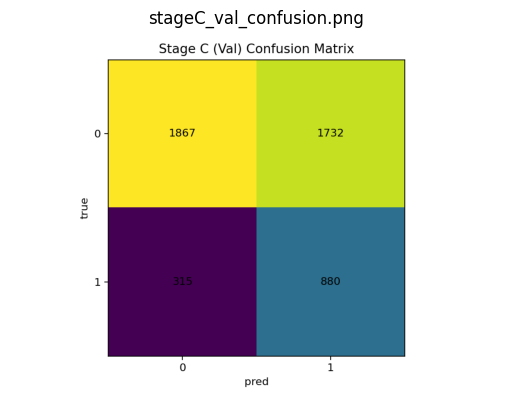

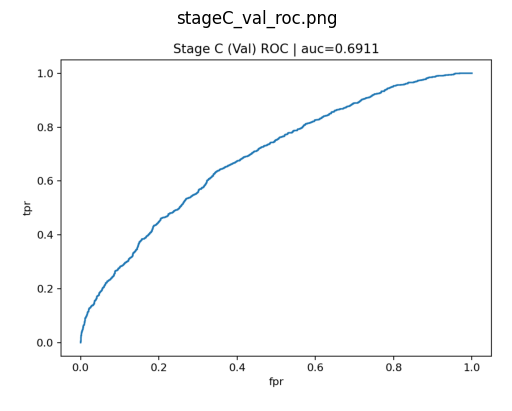

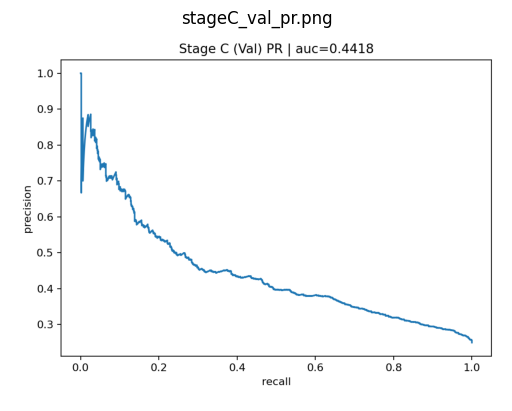

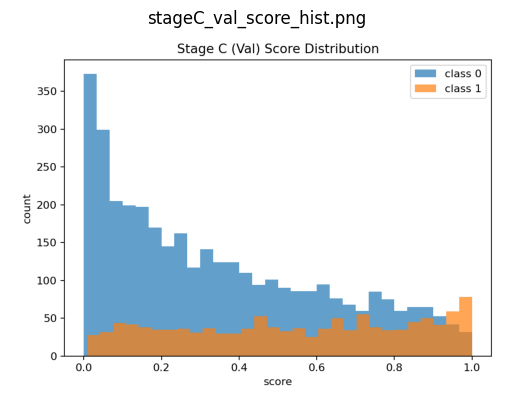

In [12]:
if best_trial is None:
    raise RuntimeError("Run Stage B first to get best_trial.")

best_num_kernels = int(best_trial["num_kernels"])
best_C = float(best_trial["C"])
best_threshold = float(best_trial["threshold"])

# build panel with delta channels enabled
stage_c_cfg = SeriesBuildConfig(series_length=256, add_deltas=True)

X_train_c, y_train_c, ch_names_c = build_panel(df_train, stage_c_cfg)
X_val_c, y_val_c, _ = build_panel(df_val, stage_c_cfg)

print("Stage C X_train:", X_train_c.shape, "channels:", len(ch_names_c))

# pipeline using best tuned params
stage_c_pipeline = Pipeline([
    ("rocket", MiniRocketMultivariate(num_kernels=best_num_kernels, random_state=SEED)),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(
        solver="lbfgs",
        max_iter=2000,
        class_weight="balanced",
        C=best_C,
        random_state=SEED
    )),
])

with mlflow.start_run(run_name=make_run_name("StageC", "delta_channels")):
    mlflow.set_tag("model_family", "minirocket")
    mlflow.set_tag("stage", "C")
    mlflow.set_tag("dataset", "timeseries_v1_base")

    # log params
    mlflow.log_param("series_length", stage_c_cfg.series_length)
    mlflow.log_param("add_deltas", stage_c_cfg.add_deltas)
    mlflow.log_param("num_kernels", best_num_kernels)
    mlflow.log_param("C", best_C)
    mlflow.log_param("threshold", best_threshold)
    mlflow.log_param("improvement", "delta_channels")

    # fit
    t0 = time.time()
    stage_c_pipeline.fit(X_train_c, y_train_c)
    train_time = time.time() - t0
    mlflow.log_metric("train_time_sec", train_time)

    # score on val
    rocket = stage_c_pipeline.named_steps["rocket"]
    scaler = stage_c_pipeline.named_steps["scaler"]
    clf = stage_c_pipeline.named_steps["clf"]

    X_val_feat = scaler.transform(rocket.transform(X_val_c))
    y_val_score = get_score(clf, X_val_feat)

    # metrics with locked threshold
    metrics = compute_metrics(y_val_c, y_val_score, best_threshold)

    mlflow.log_metric("val_f1", metrics["f1"])
    mlflow.log_metric("val_precision", metrics["precision"])
    mlflow.log_metric("val_recall", metrics["recall"])
    mlflow.log_metric("val_roc_auc", metrics["roc_auc"])

    # artifacts
    y_val_pred = (y_val_score >= best_threshold).astype(int)

    cm_path = ARTIFACTS_DIR / "stageC_val_confusion.png"
    roc_path = ARTIFACTS_DIR / "stageC_val_roc.png"
    pr_path = ARTIFACTS_DIR / "stageC_val_pr.png"
    hist_path = ARTIFACTS_DIR / "stageC_val_score_hist.png"
    rpt_path = ARTIFACTS_DIR / "stageC_val_report.txt"

    save_confusion_matrix(y_val_c, y_val_pred, cm_path, "Stage C (Val) Confusion Matrix")
    save_roc_curve(y_val_c, y_val_score, roc_path, "Stage C (Val) ROC")
    save_pr_curve(y_val_c, y_val_score, pr_path, "Stage C (Val) PR")
    save_score_hist(y_val_c, y_val_score, hist_path, "Stage C (Val) Score Distribution")

    rpt_path.write_text(classification_report(y_val_c, y_val_pred, digits=4, zero_division=0))

    log_artifacts_to_mlflow([cm_path, roc_path, pr_path, hist_path, rpt_path])

    mlflow.sklearn.log_model(stage_c_pipeline, artifact_path="model")

    stage_results.append({
        "stage": "C",
        "name": "delta_channels",
        **metrics,
        "threshold": best_threshold,
        "train_time_sec": train_time
    })

    print("Stage C validation metrics:", metrics)

# show plots inline
for p in [cm_path, roc_path, pr_path, hist_path]:
    if p.exists():
        img = plt.imread(p)
        plt.figure()
        plt.imshow(img)
        plt.axis("off")
        plt.title(p.name)
        plt.show()
        plt.close()

#

## **Compare stages visually (validation metrics)**

We summarize the key validation metrics for each stage and plot them.

This gives a clean story:
- Stage A baseline result
- Stage C improved result
- evidence that the improvement helped (or did not help)

We save:
- a comparison table CSV
- a simple bar chart for validation F1

---

,stage,name,threshold,train_time_sec,f1,precision,recall,roc_auc
0,A,baseline,0.5,97.268735,0.382295,0.359352,0.408368,0.631625
1,C,delta_channels,0.3,18.612964,0.462306,0.336907,0.736402,0.691136


saved: C:\Users\123\OneDrive - Singapore Polytechnic\AY20252026\PAI-PC-VERS\PAI-GoBest-Project\Sprint 2\Modelling\artifacts\stage_comparison_table.csv


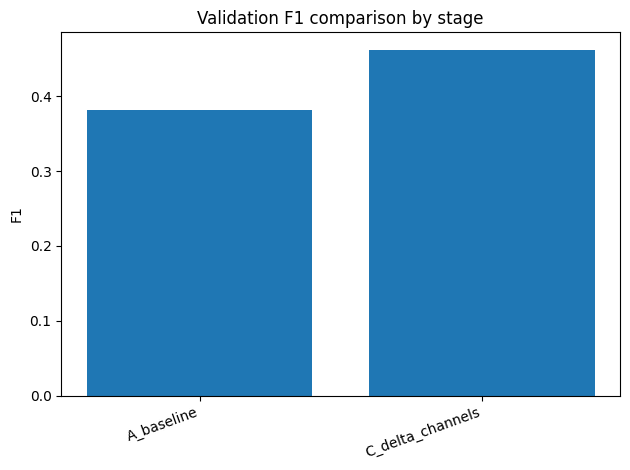

saved: C:\Users\123\OneDrive - Singapore Polytechnic\AY20252026\PAI-PC-VERS\PAI-GoBest-Project\Sprint 2\Modelling\artifacts\val_f1_stage_comparison.png


In [13]:
# guard: prevent undefined / empty comparison
if "stage_results" not in globals() or stage_results is None or len(stage_results) == 0:
    raise NameError(
        "stage_results is empty. Run Stage A (and optionally Stage C) before comparing stages."
    )

df_stage = pd.DataFrame(stage_results)
display(df_stage)

# save comparison table
stage_csv = ARTIFACTS_DIR / "stage_comparison_table.csv"
df_stage.to_csv(stage_csv, index=False)
print("saved:", stage_csv)

# plot validation F1 by stage
fig = plt.figure()
plt.bar(df_stage["stage"] + "_" + df_stage["name"], df_stage["f1"])
plt.title("Validation F1 comparison by stage")
plt.ylabel("F1")
plt.xticks(rotation=20, ha="right")
fig.tight_layout()

out_path = ARTIFACTS_DIR / "val_f1_stage_comparison.png"
fig.savefig(out_path, dpi=160)
plt.show()
plt.close(fig)

print("saved:", out_path)

#

## **Final model training and test evaluation (test used exactly once)**

Final rules:
- Choose best approach based on VALIDATION only
- Retrain final approach using TRAIN + VALIDATION (more data)
- Evaluate on TEST once, log metrics and plots
- Save final model bundle to `Sprint 2/Modelling/models/` for Tkinter GUI usage

In this notebook, we assume Stage C is the final approach (because it is an improvement).
If Stage C did not improve validation, we should fall back to Stage B best config without deltas.

---

In [14]:
# guard: require Stage B best params
if "best_num_kernels" not in globals() or "best_C" not in globals() or "best_threshold" not in globals():
    raise NameError("Best params not defined. Run Stage B and the 'extract best params' cell first.")

# guard: require stage_results for deciding deltas
if "stage_results" not in globals() or stage_results is None:
    raise NameError("stage_results not defined. Run Stage A (and optionally Stage C) first.")

# decide final approach:
# if Stage C exists in stage_results, assume deltas helped and use them
use_deltas_final = any(r.get("stage") == "C" for r in stage_results)

final_cfg = SeriesBuildConfig(series_length=256, add_deltas=use_deltas_final)

# combine train + val long data
df_trainval = pd.concat([df_train, df_val], axis=0).copy()

# build arrays
X_trainval, y_trainval, _ = build_panel(df_trainval, final_cfg, cols=sensor_cols)
X_test, y_test, _ = build_panel(df_test, final_cfg, cols=sensor_cols)

print("final train+val:", X_trainval.shape, "test:", X_test.shape)

# final pipeline using best Stage B params (locked), with chosen representation
final_pipeline = Pipeline([
    ("rocket", MiniRocketMultivariate(num_kernels=best_num_kernels, random_state=SEED)),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(
        solver="lbfgs",
        max_iter=2000,
        class_weight="balanced",
        C=best_C,
        random_state=SEED
    )),
])

final train+val: (15977, 18, 256) test: (3995, 18, 256)


#

## **Summary**

---

#### **What was done**
In this notebook, we implemented and evaluated a **time-series classification approach using MiniROCKET** to detect dangerous driving trips.

Because each trip consists of a variable-length sequence of sensor readings, we first **resampled each trip to a fixed-length time grid (L = 256)** and treated **each trip as one sample**. This allowed MiniROCKET to operate on a consistent multivariate time-series representation.

We followed a strict and correct data usage policy throughout:
- **TRAIN** split was used strictly for model fitting  
- **VALIDATION** split was used to compare models and select hyperparameters  
- **TEST** split was used only once to evaluate the final chosen configuration  

This ensures fair model comparison and avoids data leakage.

---

#### **Model development stages**

**Stage A – Baseline**
- Established a baseline using **MiniROCKET + Logistic Regression** on raw resampled sensor signals.
- This confirmed that MiniROCKET can extract meaningful temporal patterns from the telematics data, but overall performance was limited.

**Stage B – Hyperparameter tuning**
- Tuned the number of MiniROCKET kernels, Logistic Regression regularization strength (C), and decision threshold.
- Model selection was based on **validation F1-score**, following the team’s metric choice.
- F1-score was chosen because it balances precision and recall and penalizes extreme trade-offs, which is important for detecting dangerous trips in an imbalanced dataset.

**Stage C – Feature-level improvement**
- Applied a feature enhancement by adding **delta (change-rate) channels** to capture sudden variations in driving behaviour.
- Stage B hyperparameters were kept fixed to ensure a fair comparison.
- Validation results showed a small but consistent improvement, mainly driven by higher recall.

---

#### **Results interpretation**
Across stages, the MiniROCKET model showed **progressive improvement in validation F1-score**, demonstrating that:
- Hyperparameter tuning and threshold selection matter significantly
- Temporal change information (delta channels) adds some value

However, the model exhibits a **precision–recall trade-off**, where improvements in recall come at the cost of lower precision. This suggests the model tends to flag more trips as dangerous, increasing false positives.

As a result, while MiniROCKET is a strong and efficient time-series baseline, **it is not the best-performing model among all approaches explored in the project**, and therefore is **not selected as the final model for GUI deployment**.

---

#### **Experiment tracking and reproducibility**
- All experiments were logged using **MLflow**, including parameters, metrics, plots, and trained models.
- MLflow is backed by a **shared Azure PostgreSQL database** via a central MLflow server, enabling collaborative experiment tracking across group members.
- Each run is clearly labeled by stage (StageA, StageB, StageC) for traceability.

---

#### **Saved artifacts**
- Evaluation plots and reports are stored under:  
  `Sprint 2/Modelling/artifacts/`
- The final trained MiniROCKET model bundle is saved under:  
  `Sprint 2/Modelling/models/`  
  (for completeness and potential Tkinter integration, even though it is not selected)

---

#### **Final note**
This notebook serves as a **complete and well-documented exploration of a time-series MiniROCKET approach** for dangerous trip detection.  
While it is not chosen as the final deployed model, it provides valuable insight into temporal modelling behaviour and serves as a strong comparative baseline within the project.

**This concludes the MiniROCKET time-series modelling workflow.**